In [ ]:
import numpy as np
import os
import re
import math
import random
import urllib.request
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import time
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation

In [ ]:
import urllib.request
!wget https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt
!wget https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/Syllable_dictionary.txt
!wget https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/spenser.txt

--2023-03-14 06:33:23--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98029 (96K) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]  95.73K  --.-KB/s    in 0.003s  

2023-03-14 06:33:23 (26.9 MB/s) - ‘shakespeare.txt’ saved [98029/98029]

--2023-03-14 06:33:23--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/Syllable_dictionary.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent,

## Data Processing

In [ ]:
syllable_dict = {}

with open('Syllable_dictionary.txt') as f:

  for line in f:
    line = line[:-1]
    info = line.split(' ')
    if len(info) != 2:
      if info[1] in ['E1','E2','E3']:
        info.remove(info[1])
      elif info[2] in ['E1','E2','E3']:
        info.remove(info[2])
    syllable_dict[info[0]] = int (info[1])

In [ ]:
big_list = []

with open('shakespeare.txt') as f:

  curr_poem = 0

  for line in f:
    if line == '\n':
      continue

    words = line.split(' ')
    while '' in words:
      words.remove('')
    words[-1] = words[-1][:-1]

    if len(words) == 1:
      big_list.append('I AM A SPACE')
      continue

    for val in words:
      big_list.append(val)

hot_encoded = pd.factorize(big_list)

hot_encoding = {}
hot_encoding[-1] = '\n'
for ind, val in enumerate(hot_encoded[1]):
  if ind == 0:
    continue

  for char in ",./;!:?()":
    val = val.replace(char, '')

  original = val

  if val[0] == "'":
    val = val[1:]

  if val[-1] == "'":
    val = val[:-1]

  if val.lower() not in syllable_dict:
    val = original

  hot_encoding[ind - 1] = val.lower() if val != 'I' else val

poem_numbers = [[] for i in range(154)]
curr_poem = -1

for val in hot_encoded[0]:
  if val == 0:
    curr_poem += 1
    continue
  poem_numbers[curr_poem].append(val - 1)

## HMM Training

In [ ]:
def unsupervised_learning(n_states, N_iters, seed=None):
    '''
    Trains an HMM using supervised learning on the file 'ron.txt' and
    prints the results.
    Arguments
        n_states:   Number of hidden states that the HMM should have.
        N_iters:    Number of EM steps taken.
        rng:        The random number generator used. Default to 1.
    '''

    # Train the HMM.
    HMM = unsupervised_HMM(poem_numbers, n_states, N_iters, seed=seed)

    # Print the transition matrix.
    print("Transition Matrix:")
    print('#' * 70)
    for i in range(len(HMM.A)):
        print(''.join("{:<12.3e}".format(HMM.A[i][j]) for j in range(len(HMM.A[i]))))
    print('')
    print('')

    # Print the observation matrix.
    print("Observation Matrix:  ")
    print('#' * 70)
    for i in range(len(HMM.O)):
        print(''.join("{:<12.3e}".format(HMM.O[i][j]) for j in range(len(HMM.O[i]))))
    print('')

    return HMM


HMM_data = unsupervised_learning(25, 100, seed=1)

Transition Matrix:
######################################################################
3.688e-48   2.391e-03   9.904e-69   3.058e-02   1.258e-74   7.257e-62   1.404e-02   1.623e-28   1.054e-34   1.148e-80   1.649e-03   1.002e-56   2.478e-90   3.156e-68   2.269e-55   8.274e-59   2.215e-54   2.430e-86   4.036e-66   8.004e-55   8.162e-03   4.644e-37   2.063e-44   1.815e-01   7.617e-01   
1.557e-72   3.192e-51   5.466e-26   3.786e-94   6.618e-01   4.394e-45   1.237e-51   2.686e-03   6.790e-25   3.908e-25   7.480e-02   4.494e-48   2.832e-96   3.907e-95   5.264e-58   6.194e-53   1.579e-01   5.999e-73   1.374e-100  3.698e-38   3.651e-60   1.650e-59   1.028e-01   5.601e-26   5.480e-11   
4.851e-33   6.305e-44   2.642e-36   3.250e-21   1.230e-97   1.771e-62   2.546e-01   3.027e-15   2.686e-16   2.232e-20   1.447e-42   9.395e-30   1.806e-21   4.655e-55   3.144e-03   4.377e-37   2.232e-37   1.049e-29   1.608e-01   5.403e-01   1.114e-33   5.222e-18   4.116e-02   1.431e-39   7.511e-58   
6.218e-

In [ ]:
ten_best_words = []

for hidden_state in HMM_data.O:
  map = {}
  for i in range(len(hidden_state)):
    map[hidden_state[i]] = i
  hidden_state.sort()
  ten_best_words.append([])
  for i in range (0,10):
    ten_best_words[len(ten_best_words)-1].append(hot_encoding[map.get(hidden_state[len(hidden_state)-(1+i)])])

print(ten_best_words)

[['love', 'self', 'not', 'thou', 'heart', 'but', 'love', 'why', 'and', 'will'], ['of', 'to', 'the', 'so', 'or', 'be', 'own', 'for', 'and', 'eye'], ['of', 'with', 'all', 'in', 'have', 'and', 'on', 'a', 'from', 'he'], ['and', 'I', 'which', 'that', 'so', 'the', 'when', 'thou', 'for', 'where'], ['and', 'by', 'o', 'to', 'that', 'then', 'with', 'nor', 'am', 'my'], ['the', 'this', 'a', 'thee', 'but', 'you', 'your', 'have', 'they', 'and'], ['in', 'to', 'is', 'do', 'the', 'for', 'with', 'as', 'should', 'that'], ['that', 'thee', 'did', 'thee', 'more', 'thy', 'be', 'mine', 'might', 'to'], ['the', 'of', 'to', 'that', 'all', 'when', 'a', 'do', 'for', 'but'], ['a', 'self', 'and', 'I', 'as', 'that', 'hath', 'can', "beauty's", 'to'], ['my', 'thy', 'not', 'doth', 'me', 'be', 'your', 'is', 'a', 'sweet'], ['I', 'to', 'and', 'no', 'thee', 'this', 'that', 'would', 'world', 'yet'], ['I', 'thou', 'it', 'you', 'but', 'not', 'me', 'or', 'love', 'her'], ['in', 'to', 'is', 'it', 'on', 'from', 'a', 'that', 'be', 

In [ ]:

words= [['love', 'self', 'not', 'thou', 'heart', 'but', 'love', 'why', 'and', 'will'], ['of', 'to', 'the', 'so', 'or', 'be', 'own', 'for', 'and', 'eye'], ['of', 'with', 'all', 'in', 'have', 'and', 'on', 'a', 'from', 'he'], ['and', 'I', 'which', 'that', 'so', 'the', 'when', 'thou', 'for', 'where'], ['and', 'by', 'o', 'to', 'that', 'then', 'with', 'nor', 'am', 'my'], ['the', 'this', 'a', 'thee', 'but', 'you', 'your', 'have', 'they', 'and'], ['in', 'to', 'is', 'do', 'the', 'for', 'with', 'as', 'should', 'that'], ['that', 'thee', 'did', 'thee', 'more', 'thy', 'be', 'mine', 'might', 'to'], ['the', 'of', 'to', 'that', 'all', 'when', 'a', 'do', 'for', 'but'], ['a', 'self', 'and', 'I', 'as', 'that', 'hath', 'can', "beauty's", 'to'], ['my', 'thy', 'not', 'doth', 'me', 'be', 'your', 'is', 'a', 'sweet'], ['I', 'to', 'and', 'no', 'thee', 'this', 'that', 'would', 'world', 'yet'], ['I', 'thou', 'it', 'you', 'but', 'not', 'me', 'or', 'love', 'her'], ['in', 'to', 'is', 'it', 'on', 'from', 'a', 'that', 'be', 'thy'], ['his', 'the', 'thy', 'and', 'that', 'their', 'mine', 'but', 'thine', 'well']]
for groups in words:
  print(groups)

['love', 'self', 'not', 'thou', 'heart', 'but', 'love', 'why', 'and', 'will']
['of', 'to', 'the', 'so', 'or', 'be', 'own', 'for', 'and', 'eye']
['of', 'with', 'all', 'in', 'have', 'and', 'on', 'a', 'from', 'he']
['and', 'I', 'which', 'that', 'so', 'the', 'when', 'thou', 'for', 'where']
['and', 'by', 'o', 'to', 'that', 'then', 'with', 'nor', 'am', 'my']
['the', 'this', 'a', 'thee', 'but', 'you', 'your', 'have', 'they', 'and']
['in', 'to', 'is', 'do', 'the', 'for', 'with', 'as', 'should', 'that']
['that', 'thee', 'did', 'thee', 'more', 'thy', 'be', 'mine', 'might', 'to']
['the', 'of', 'to', 'that', 'all', 'when', 'a', 'do', 'for', 'but']
['a', 'self', 'and', 'I', 'as', 'that', 'hath', 'can', "beauty's", 'to']
['my', 'thy', 'not', 'doth', 'me', 'be', 'your', 'is', 'a', 'sweet']
['I', 'to', 'and', 'no', 'thee', 'this', 'that', 'would', 'world', 'yet']
['I', 'thou', 'it', 'you', 'but', 'not', 'me', 'or', 'love', 'her']
['in', 'to', 'is', 'it', 'on', 'from', 'a', 'that', 'be', 'thy']
['his',

## Haikus

In [ ]:
for k in range(6):
  emission, state = HMM_data.generate_haiku_emission(syllable_dict, hot_encoding, seed=12)
  x = ' '.join([hot_encoding[i] for i in emission])

  x = x.replace(' \n ', '\n')

  # Print the results.
  print("{:30}".format(x))

and thus despite thy
and o that substance thou the
governs thee field tell 

imitate saved view
watery tops the deeds discased
proud are and thou and 

life and of my is
my glass our like grief silvered
for bore might on fair 

all inheritors
art of if wert the for which
steel deserts if to 

not wit translate be
art rather to the am slay
teach common and were 

divide hath strive I
my true the not happies and
praise my as me a 



## Sonnet (14 lines 10 syllables)

In [ ]:
for k in range(1):
  emission, state = HMM_data.generate_shakespeare_emission(14, syllable_dict, hot_encoding, seed=12)
  x = ' '.join([hot_encoding[i] for i in emission])

  x = x.replace(' \n ', '\n')

  # Print the results.
  print("{:30}".format(x))

NameError: ignored

In [ ]:
"""
10:

15:
storm-beaten feathered draw answer dove with
absence usurer may I deemed thou green
store gives love's time the my extremity
me to hath would cross love the being of died
beard waning want pry charge thy judgement eye
and to a those to to thy form shall I
the their whose my o'er deep divert my live
shalt in my self pine thine to I things old
will nay powers borne of a behold i'll the
happy the words precious powerful sire with
perfection like so with died and dreams shall
live of from still mountain you better think
determinate art pity is be be
bed wand'rest muse in i'll if yet cheered in

20:
away thou thy mistress with found but and
spirit thou fair of at o this of their once
how is sweet love of wherein thought consent
slavery yellow when sufficed read thou my
a with how dost mine sum stand know your their
badges waking pyramids before chief
countenance way homage none worth victors
both foiled immured mine my graces doth
might their these beauteous in in will it from
shall the dull hue survive the think define
numbers am of can if horse in unkind
impute they which I question terms my might
reeks can I commend every thy dear sin
I no of against the most look sweet have
"""

## Additional Training Data (Spencer.txt)

In [ ]:
big_list = []

# Initial Shakespeare
with open('shakespeare.txt') as f:
  curr_poem_f = 0
  for line in f:
    if line == '\n':
      continue
    words = line.split(' ')
    while '' in words:
      words.remove('')
    words[-1] = words[-1][:-1]
    if len(words) == 1:
      big_list.append('I AM A SPACE')
      continue
    for val in words:
      big_list.append(val)

#Spencer
with open('spenser.txt') as g:
  curr_poem_g = 0
  for line in g:
    if line == '\n':
      continue
    words = line.split(' ')
    while '' in words:
      words.remove('')
    words[-1] = words[-1][:-1]
    if len(words) == 1:
      if words == [':poem']:
        continue
      big_list.append('I AM A SPACE')
      continue
    for val in words:
      big_list.append(val)

hot_encoded = pd.factorize(big_list)
hot_encoding = {}
hot_encoding[-1] = '\n'
for ind, val in enumerate(hot_encoded[1]):
  if ind == 0:
    continue
  for char in ",./;!:?()":
    val = val.replace(char, '')
  hot_encoding[ind - 1] = val.lower() if val != 'I' else val
poem_numbers = [[] for i in range(154+88)]
curr_poem = -1

for val in hot_encoded[0]:
  if val == 0:
    curr_poem += 1
    continue
  poem_numbers[curr_poem].append(val - 1)

np.random.shuffle(poem_numbers)

In [ ]:
def unsupervised_learning(n_states, N_iters, seed=None):
    '''
    Trains an HMM using supervised learning on the file 'ron.txt' and
    prints the results.
    Arguments
        n_states:   Number of hidden states that the HMM should have.
        N_iters:    Number of EM steps taken.
        rng:        The random number generator used. Default to 1.
    '''

    # Train the HMM.
    HMM = unsupervised_HMM(poem_numbers, n_states, N_iters, seed=seed)

    # Print the transition matrix.
    print("Transition Matrix:")
    print('#' * 70)
    for i in range(len(HMM.A)):
        print(''.join("{:<12.3e}".format(HMM.A[i][j]) for j in range(len(HMM.A[i]))))
    print('')
    print('')

    # Print the observation matrix.
    print("Observation Matrix:  ")
    print('#' * 70)
    for i in range(len(HMM.O)):
        print(''.join("{:<12.3e}".format(HMM.O[i][j]) for j in range(len(HMM.O[i]))))
    print('')

    return HMM


HMM_data = unsupervised_learning(10, 100, seed=1)

Transition Matrix:
######################################################################
2.926e-10   5.316e-01   3.101e-37   2.532e-01   2.468e-47   7.665e-07   1.958e-01   8.326e-04   1.865e-02   1.911e-29   
4.968e-01   2.495e-02   9.161e-04   4.774e-01   1.619e-36   3.013e-17   1.750e-24   5.032e-14   6.497e-28   5.383e-22   
1.087e-02   4.394e-17   3.065e-26   3.743e-01   4.947e-01   1.201e-01   1.541e-42   6.842e-25   7.221e-11   1.113e-14   
4.938e-18   8.123e-19   5.513e-16   4.538e-02   8.300e-22   9.546e-01   1.244e-12   1.405e-18   2.621e-10   9.338e-43   
4.587e-03   4.238e-01   1.395e-24   9.815e-02   1.835e-01   2.261e-22   3.680e-33   3.718e-02   1.070e-32   2.528e-01   
4.586e-15   1.428e-01   6.720e-31   3.735e-02   1.717e-16   1.105e-23   1.989e-01   6.129e-02   5.597e-01   5.648e-19   
1.965e-36   1.711e-24   1.509e-18   1.605e-36   2.582e-02   4.047e-49   5.279e-51   4.519e-34   8.373e-02   8.905e-01   
1.373e-11   3.605e-13   5.930e-02   1.549e-09   3.420e-36   6.6

In [ ]:
for k in range(14):
  emission, state = HMM_data.generate_emission(10, seed=12)
  x = ' '.join([hot_encoding[i] for i in emission])

  x = x.replace(' \n ', '\n')

  # Print the results.
  print("{:30}".format(x))

made on o'ercharged and is ne those I seem
writers cannot bright far rest but being pity lothsome
and to liberty thee change mind thou oft many
 cruel trespass a her lodging of t'abide lovers
my await lead with I forsworn then do day
amearst a the love and false do a this
mercy is that my records to some be the
worth son thy her and be endless all lov'st
me unkind rest thou I angel burthens love on
we form there then and intent a the have
 dost to powerful your like a love well
to thy mine doth shows ghost can hate well
dare my dark live all is pill desire most
the but an astronomy engrafted eternal power both not


## Outputs

In [ ]:
"""
NAIVE
5 hidden states:
call me my be desire falls died with state too is nature make
thou of wastes by love praise were precious to each my a a
leads and winter's replete new of win being lays flourish my roses beds'
with waste and a bright poor this of the words more kind on
life sigh tongue: hide you fear he's mistress for if o in presagers
bearing: but vacant some when whose but of farthest come sworn stands love's

10 hidden states:
wait that whilst shalt me from their ordering; robbing dream of bath losses
when worth hold seek dispense my bear the compare glory eye love thee
make affections famine that and are desire and right him did dateless monsters
to doth welcome new tired brains when purpose doth thine in the found
of mine orient hath costs new love who for they be what in
behold be controlling my tongue's he to lie tell; please sin state beauty

15 hidden states: (removed semilcolons)
that world's to it and eyes remembered this rich minutes and sure from
time's while being the backward three wrackful the and blame your plead picture
gross night own thy depends: where husband me thought thou doth brow change
could everywhere! once show my not art cup hath thy poor shall a
I by our unmoved and hell your with my as my daily else
this have when physic you call taken the from you eternal straight thine

20 hidden states:
should buried for he story by her self turns my others ransom the
by and knowledge not to so woe not false not to very yield
parts and rehearse before where born see your stop so how in that
young in tie couldst the love of whoe'er hath in wide self and
but kill best sea thou whom my now above may and as the
I be a of no one lust of hammered more o if no

WITH SYLLABLE COUNTS


HAIKUS

5 hidden states:
my false if corrupt
jewels am cross finger no
not in in can me

the why proved muse urge
up thy which light truth beseem
censures report form

way thee age will both
only thee a you eyes his
die mine but saw not

at how need the see
and that dial's thou loved that
beautiful thou drugs

grows to a thoughts thou
name strong and th' receiv'st do with
your place his foregone

their see tired so thee
the most in mine the me to
be stay take cannot

10 hidden states:
this is fairest and
on tears expense as I signs
than mine and and brand

that of is in and
thy love on in if that store's
forgoing what are

trifles each see joy
your time beside absence speed
pleasure wail in thy

of benefit saw
and than do upon to as
clearer all of to

unkind famoused place
so fine in the doth mountain
inconstant to still

in your though he this
when all which as and as when
told my writ hides so

15 hidden states:
in he termed fall beast
that trust best which enough thou
as muse doth most cast

still nor register
thee when things of they sight and
of I my first shalt

let labouring though live
time find region their to thine
thy breath wherein greater

why may fears to her
to they so and doth made straight
sleep his own knights true

or have self-loving
came the strong varying no your
the time-bettering blamed

hast scarcely that it
tongue and away love good and
would thee over not

20 hidden states:
but leap art there things
am hate's should I trouble one finds
when thou and to quite

such awake follow
sweet sweet bones and straight the owe
blamed a it true and

our still our brow or
his bliss rocks beast surmise that
I and love die of

own into world's till
respects receiv'st shall of thou
dull you indigest

pity and there me
bonds but the their saint let let
his treasure with to

WITH SPENCER (ADDITIONAL DATA):

life fulfil that I bears eye aright go heaven and sit violet absence
"""

## Visualizations

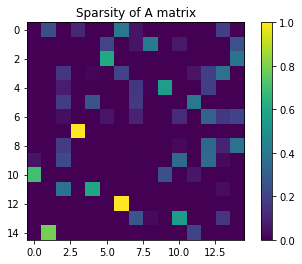

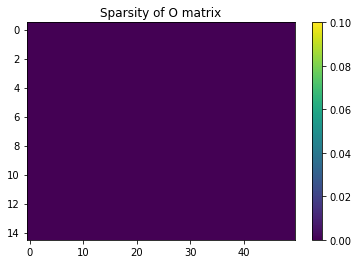

In [ ]:
visualize_sparsities(HMM_data, O_max_cols=50)

In [ ]:
from IPython.core.async_helpers import indent
# You can use this skeleton code to complete the HMM
# implementation of set 5. Once each part is implemented, you can simply
# execute the related problem scripts (e.g. run 'python 2G.py') to quickly
# see the results from your code.
#
# Some pointers to get you started:
#
#     - Choose your notation carefully and consistently! Readable
#       notation will make all the difference in the time it takes you
#       to implement this class, as well as how difficult it is to debug.
#
#     - Read the documentation in this file! Make sure you know what
#       is expected from each function and what each variable is.
#
#     - Any reference to "the (i, j)^th" element of a matrix T means that
#       you should use T[i][j].
#
#     - Note that in our solution code, no NumPy was used. That is, there
#       are no fancy tricks here, just basic coding. If you understand HMMs
#       to a thorough extent, the rest of this implementation should come
#       naturally. However, if you'd like to use NumPy, feel free to.
#
#     - Take one step at a time! Move onto the next algorithm to implement
#       only if you're absolutely sure that all previous algorithms are
#       correct. We are providing you waypoints for this reason.
#
# To get started, just fill in code where indicated. Best of luck!

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.

            D:          Number of observations.

            A:          The transition matrix.

            O:          The observation matrix.

            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]


        BIG_LOG_NEGATIVE = -100000

        for start_num in range(self.L):
          A_init = self.A_start[start_num]
          A_t = math.log(A_init) if A_init != 0 else BIG_LOG_NEGATIVE
          O_init = self.O[start_num][x[0]]
          O_t = math.log(O_init) if O_init != 0 else BIG_LOG_NEGATIVE

          probs[1][start_num] = A_t + O_t
          seqs[1][start_num] = str (start_num)

        for row in range(2, M + 1):
          for a in range(self.L):
            max_val = BIG_LOG_NEGATIVE
            max_order = ''

            O = self.O[a][x[row - 1]]
            O_t = math.log(O) if O != 0 else BIG_LOG_NEGATIVE

            for ind, prev in enumerate(seqs[row - 1]):
              prev_letter = int (prev[-1])
              P_t = probs[row - 1][ind]

              A = self.A[prev_letter][a]
              A_t = math.log(A) if A != 0 else BIG_LOG_NEGATIVE

              new_val = P_t + A_t
              if new_val > max_val:
                max_val = new_val
                max_order = prev

            probs[row][a] = max_val + O_t
            seqs[row][a] = max_order + (str (a))

        max_ind = np.argmax(probs[-1])

        return seqs[-1][max_ind]


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        tot = 0
        for i in range(self.L):
          alphas[1][i] = self.A_start[i] * self.O[i][x[0]]
          tot += alphas[1][i]

        if normalize:
          for i in range(self.L):
            alphas[1][i] /= tot


        for row in range(2, M + 1):
          tot = 0
          for a in range(self.L):
            sum = 0
            for ap in range(self.L):
              sum += alphas[row - 1][ap] * self.A[ap][a]

            alphas[row][a] = self.O[a][x[row - 1]] * sum
            tot += alphas[row][a]

          if normalize:
            for i in range(self.L):
              alphas[row][i] /= tot

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]


        betas[M] = [1] * self.L

        if normalize:
          for i in range(self.L):
            betas[M][i] /= self.L


        for row in range(M - 1, -1, -1):
          tot = 0
          for b in range(self.L):

            sum = 0
            for bp in range(self.L):
              beta_diff = betas[row + 1][bp]
              P_x = self.O[bp][x[row]]
              if row != 0:
                P_y = self.A[b][bp]
              else:
                P_y = self.A_start[b]
              sum += beta_diff * P_x * P_y

            betas[row][b] = sum
            tot += betas[row][b]

          if normalize:
            for i in range(self.L):
              betas[row][i] /= tot

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''



        # Calculate each element of A using the M-step formulas.
        for a in range(self.L):
          for b in range(self.L):

            num = 0
            denom = 0
            for Y_lst in Y:
              for ind, val in enumerate(Y_lst[:-1]):
                y_i_k1 = val == a
                y_i_k = Y_lst[ind + 1] == b
                denom += y_i_k1
                num += (y_i_k and y_i_k1)

            self.A[a][b] = num / denom

        # Calculate each element of O using the M-step formulas.

        for w in range(self.D):
          for a in range(self.L):

            num = 0
            denom = 0
            for lst_ind, Y_lst in enumerate(Y):
              for ind, val in enumerate(Y_lst):
                x_i_k = X[lst_ind][ind] == w
                y_i_k = val == a
                num += (x_i_k and y_i_k)
                denom += y_i_k

            self.O[a][w] = num / denom

        pass


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
        '''

        ### TODO: Insert Your Code Here (2D)

        for epoch in range(N_iters):



          new_A_num = [[0. for _ in range(self.L)] for _ in range(self.L)]
          new_A_denom = [0. for _ in range(self.L)]


          new_O_num = [[0. for _ in range(self.D)] for _ in range(self.L)]
          new_O_denom = [0. for _ in range(self.L)]

          for ind, seq in enumerate(X):
              alphas = self.forward(seq, normalize=True)
              betas = self.backward(seq, normalize=True)

              for i in range(1, len(seq)):
                A_denom_top = 0
                A_denom_bottom = 0
                for ap in range(self.L):
                  for bp in range(self.L):
                    A_denom_top += alphas[i][ap] * self.O[bp][seq[i]] * self.A[ap][bp] * betas[i + 1][bp]
                  A_denom_bottom += alphas[i][ap] * betas[i][ap]

                for a in range(self.L):
                  for b in range(self.L):
                    new_A_num[a][b] += alphas[i][a] * self.O[b][seq[i]] * self.A[a][b] * betas[i + 1][b] / A_denom_top
                  new_A_denom[a] += alphas[i][a] * betas[i][a] / A_denom_bottom

              for i in range(1, len(seq) + 1):
                  denom = 0
                  for ap in range(self.L):
                    denom += alphas[i][ap] * betas[i][ap]
                  for a in range(self.L):
                    new_O_num[a][seq[i - 1]] += alphas[i][a] * betas[i][a] / denom
                    new_O_denom[a] += alphas[i][a] * betas[i][a] / denom

          for i in range(self.L):
            for j in range(self.L):
              self.A[i][j] = new_A_num[i][j] / new_A_denom[i]

          for i in range(self.L):
            for j in range(self.D):
              self.O[i][j] = new_O_num[i][j] / new_O_denom[i]


    def generate_emission(self, M, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        state = np.random.randint(self.L)


        for i in range(1, M):
          new = np.random.choice(self.D, p=self.O[state])
          emission.append(new)
          state = np.random.choice(self.L, p=self.A[state])
          states.append(state)

        return emission, states

    def generate_shakespeare_emission(self, lines, syllable_data, word_data, seed=None):
        """
        Generate emission with 10 syllables per line
        as shakespeare would have
        """
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        state = np.random.randint(self.L)

        for i in range(lines):
          syll_count = 10
          curr_syll = 0
          while curr_syll != syll_count:
            new = np.random.choice(self.D, p=self.O[state])

            new_word = word_data[new].lower()
            new_word_syllables = syllable_data[new_word]

            count = 0

            while curr_syll + new_word_syllables > syll_count:
              new = np.random.choice(self.D, p=self.O[state])
              new_word = word_data[new].lower()
              new_word_syllables = syllable_data[new_word]

              if count == 1000:
                print('CAN NOT DO THIS')
                return

              count += 1

            curr_syll += new_word_syllables

            emission.append(new)
            state = np.random.choice(self.L, p=self.A[state])
            states.append(state)
          emission.append(-1)
        return emission, states

    def generate_haiku_emission(self, syllable_data, word_data, seed=None):
        """
        Generate a haiku
        """

        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        state = np.random.randint(self.L)


        for i in range(3):
          syll_count = 7 if i == 1 else 5
          curr_syll = 0
          while curr_syll != syll_count:
            new = np.random.choice(self.D, p=self.O[state])

            new_word = word_data[new].lower()
            new_word_syllables = syllable_data[new_word]

            count = 0

            while curr_syll + new_word_syllables > syll_count:
              new = np.random.choice(self.D, p=self.O[state])
              new_word = word_data[new].lower()
              new_word_syllables = syllable_data[new_word]

              if count == 1000:
                print('CAN NOT DO THIS')
                return

              count += 1

            curr_syll += new_word_syllables

            emission.append(new)
            state = np.random.choice(self.L, p=self.A[state])
            states.append(state)
          emission.append(-1)



        return emission, states



    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)

    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters, seed=None):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.

        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''
    # Initialize random number generator
    rng = np.random.default_rng(seed=seed)

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

In [ ]:
########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []

        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1

            # Add the encoded word.
            obs_elem.append(obs_map[word])

        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words, seed=seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1, seed=None):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06

    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)

    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)

            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M, seed=seed)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim


In [ ]:
class Utility:
    '''
    Utility for the problem files.
    '''

    def __init__():
        pass

    @staticmethod
    def load_sequence(n):
        '''
        Load the file 'sequence_data<n>.txt' for a given n.
        Arguments:
            n:          Sequence index.
        Returns:
            A:          The transition matrix.
            O:          The observation matrix.
            seqs:       Input sequences.
        '''
        A = []
        O = []
        seqs = []

        # For each file:
        with urllib.request.urlopen(f'https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set6/data/sequence_data{n}.txt') as f:
            # Read the parameters.
            L, D = [int(x) for x in f.readline().decode('utf-8').strip().split('\t')]

            # Read the transition matrix.
            for i in range(L):
                A.append([float(x) for x in f.readline().decode('utf-8').strip().split('\t')])

            # Read the observation matrix.
            for i in range(L):
                O.append([float(x) for x in f.readline().decode('utf-8').strip().split('\t')])

            # The rest of the file consists of sequences.
            while True:
                seq = f.readline().decode('utf-8').strip()
                if seq == '':
                    break
                seqs.append([int(x) for x in seq])

        return A, O, seqs

    @staticmethod
    def load_ron():
        '''
        Loads the file 'ron.txt'.
        Returns:
            moods:      Sequnces of states, i.e. a list of lists.
                        Each sequence represents half a year of data.
            mood_map:   A hash map that maps each state to an integer.
            genres:     Sequences of observations, i.e. a list of lists.
                        Each sequence represents half a year of data.
            genre_map:  A hash map that maps each observation to an integer.
        '''
        moods = []
        mood_map = {}
        genres = []
        genre_map = {}
        mood_counter = 0
        genre_counter = 0

        with urllib.request.urlopen("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set6/data/ron.txt") as f:
            mood_seq = []
            genre_seq = []

            while True:
                line = f.readline().decode('utf-8').strip()

                if line == '' or line == '-':
                    # A half year has passed. Add the current sequence to
                    # the list of sequences.
                    moods.append(mood_seq)
                    genres.append(genre_seq)
                    # Start new sequences.
                    mood_seq = []
                    genre_seq = []

                if line == '':
                    break
                elif line == '-':
                    continue

                mood, genre = line.split()

                # Add new moods to the mood state hash map.
                if mood not in mood_map:
                    mood_map[mood] = mood_counter
                    mood_counter += 1

                mood_seq.append(mood_map[mood])

                # Add new genres to the genre observation hash map.
                if genre not in genre_map:
                    genre_map[genre] = genre_counter
                    genre_counter += 1

                # Convert the genre into an integer.
                genre_seq.append(genre_map[genre])

        return moods, mood_map, genres, genre_map

    @staticmethod
    def load_ron_hidden():
        '''
        Loads the file 'ron.txt' and hides the states.
        Returns:
            genres:     The observations.
            genre_map:  A hash map that maps each observation to an integer.
        '''
        moods, mood_map, genres, genre_map = Utility.load_ron()

        return genres, genre_map